In [1]:
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_spiral_dataset
tf.random.set_seed(42)


### PLot functions

In [2]:
def plot_scatter(X:np.ndarray, Y:np.ndarray):
    '''
    Show the scatter plot of flower dataset
    
    Parameters
    ----------
    X : numpy.ndarray [shape: (#features, #samples)]
        matrix of data; dtype: float64
    Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1; dtype: uint8 
    '''
    scatter=plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)
    plt.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    # plt.show()
    

def plot_decision_boundary(predict, X, Y):
    """
    Plot the decision boundary for logistic regression
    
    Parameters
    ----------
    predict : function
        predicted output; dtype=int8 
    parameters : dict
    X : numpy.ndarray [shape: (#features, #samples)]
        matrix of data; dtype: float64
    Y : numpy.ndarray [shape: (1, #samples)]
        array containing true labels 0 or 1; dtype: uint8
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    # Y = None argument is dumpy as not used when print_accuracy=False
    a=tf.constant(np.c_[xx.ravel(), yy.ravel()],dtype=tf.float32)
    Z = predict(a)
    Z = tf.argmax(Z, axis=-1)
    Z = Z.numpy().reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plot_scatter(X,Y)
    # plt.xlim(-1.1, 1.1)
    # plt.ylim(-1.1, 1.1)

### Import data

(1000, 2) (1000, 1)


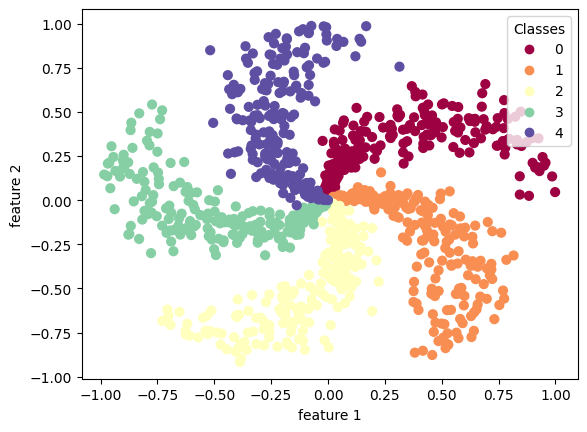

In [3]:
X_np,Y_np = load_spiral_dataset(N=1000, noise=0.2, K=5) # x->(D,N), y->(1,N)
X=tf.constant(X_np.T, dtype=tf.float32) # x->(N,D)=(1000,2)
Y=tf.constant(Y_np.reshape(-1,1), dtype=tf.uint8) # y->(N,1)=(1000,1)
print(X.shape, Y.shape)
plot_scatter(X_np,Y_np)

In [4]:
unique_labels = tf.unique(tf.squeeze(Y)).y
unique_labels

<tf.Tensor: shape=(5,), dtype=uint8, numpy=array([0, 1, 2, 3, 4], dtype=uint8)>

In [5]:
Y_true = tf.one_hot( Y[:,-1], depth=5 )

In [6]:
Y_true[::100]

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

### L Layer Neural Network Model

In [7]:
def L_layer_model(train_X, train_Y, layers_dims, learning_rate=0.0075, num_epochs=2000, activation_L_1="relu", activation_L="sigmoid", print_cost=False):
    """
    L layer neural network with different activation function on output layer option.
    
    Parameters
    ----------
    train_X : Tensor [shape: (#samples, #features)]; dtype=tf.float32
    train_Y : Tensor [shape: (#samples, 1)]; dtype=tf.float32
    layers_dims : list of int; list of number of nodes in each layer

    Returns
    -------
    forward : trained model
    costs : list of cost every 100 iteration
    """
    costs = []                                        # To keep track of the cost
    L = len(layers_dims) # number of layers in the network
    k.utils.set_random_seed(42)

    ## Initialize model
    forward = k.models.Sequential()
    # layers initialized; [1:L-1] X activation_L_1 + [L] X activation_L
    for l in range(1, L-1):
        forward.add( k.layers.Dense(units=layers_dims[l], activation=activation_L_1, input_shape=(layers_dims[l-1],),
                                    kernel_initializer=k.initializers.HeUniform(), bias_initializer="zeros") )
    forward.add( k.layers.Dense(units=layers_dims[-1], activation=activation_L, input_shape=(layers_dims[-2],),
                                kernel_initializer=k.initializers.GlorotUniform(), bias_initializer="zeros") )
    # forward.summary()

    ## Initialize build-in classes
    bce = tf.keras.losses.CategoricalCrossentropy( from_logits=False, reduction='sum')
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    ## epochs loop
    for i in range(num_epochs):
        ## forward pass
        with tf.GradientTape() as tape:
            train_Y_pred = forward(train_X)       # (209,n_L)=(m,n_L)
            cost = bce(train_Y, train_Y_pred)

        ## backward pass
        grads = tape.gradient(cost, forward.trainable_weights)
        optimizer.apply_gradients(zip(grads, forward.trainable_weights))

        ## Record the cost every 100 iterations
        if i % 100 == 0 or i == num_epochs-1:
            costs.append(cost.numpy().item())
            if print_cost:
                print(f"Cost in epochs {i+1}, {cost.numpy().item()}")

    return forward, costs


def plot_costs(costs, learning_rate):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

### Detailed info, plots demo

Cost in epochs 1, 1620.271484375
Cost in epochs 101, 1259.5484619140625
Cost in epochs 201, 792.2947998046875
Cost in epochs 301, 470.357421875
Cost in epochs 401, 316.32720947265625
Cost in epochs 501, 239.84295654296875
Cost in epochs 601, 194.44210815429688
Cost in epochs 701, 162.2424774169922
Cost in epochs 801, 136.1883544921875
Cost in epochs 901, 115.75841522216797
Cost in epochs 1001, 99.45316314697266
Cost in epochs 1101, 85.77587890625
Cost in epochs 1201, 74.44304656982422
Cost in epochs 1301, 65.2764892578125
Cost in epochs 1401, 57.87232971191406
Cost in epochs 1501, 51.95857238769531
Cost in epochs 1601, 47.09546661376953
Cost in epochs 1701, 42.93870544433594
Cost in epochs 1801, 39.469669342041016
Cost in epochs 1901, 36.493202209472656
Cost in epochs 2000, 33.95026397705078
train accuracy: 99.40000176429749 %


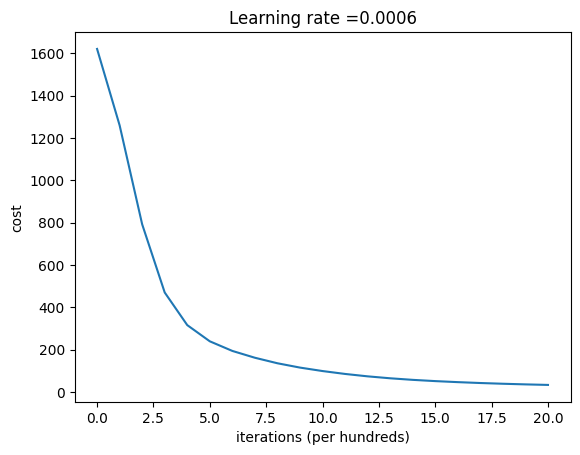

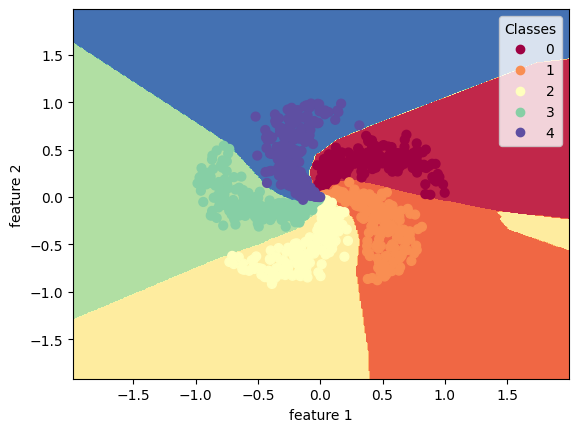

In [8]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1],12,12,12, 5]

forward, costs = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=True)
Y_pred=forward(X)
acc = k.metrics.CategoricalAccuracy()
acc.update_state(Y_true, Y_pred)
print(f"train accuracy: { acc.result().numpy().item() *100 } %")
plot_costs(costs, learning_rate)
plot_decision_boundary(forward, X_np, Y_np)

### Single Layer(Output layer) Model Run

Cost in epochs 1, 1575.916015625
Cost in epochs 101, 1543.7742919921875
Cost in epochs 201, 1513.288818359375
Cost in epochs 301, 1484.18603515625
Cost in epochs 401, 1456.343505859375
Cost in epochs 501, 1429.6544189453125
Cost in epochs 601, 1404.027099609375
Cost in epochs 701, 1379.3837890625
Cost in epochs 801, 1355.657958984375
Cost in epochs 901, 1332.7919921875
Cost in epochs 1001, 1310.73486328125
Cost in epochs 1101, 1289.443359375
Cost in epochs 1201, 1268.878173828125
Cost in epochs 1301, 1249.00439453125
Cost in epochs 1401, 1229.790283203125
Cost in epochs 1501, 1211.20654296875
Cost in epochs 1601, 1193.224853515625
Cost in epochs 1701, 1175.8193359375
Cost in epochs 1801, 1158.96435546875
Cost in epochs 1901, 1142.6358642578125
Cost in epochs 2000, 1126.966552734375
train accuracy: 70.59999704360962 %


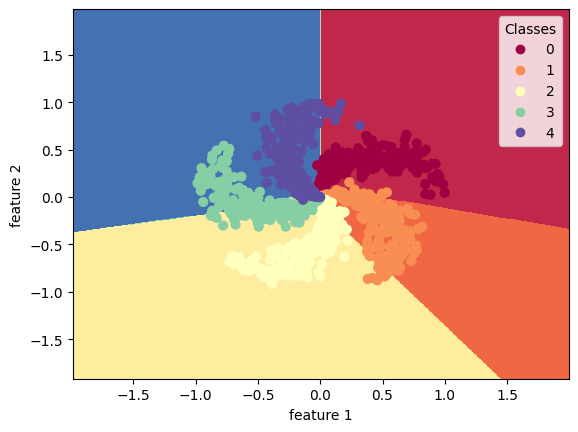

In [9]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1], 5]

forward, costs = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=True)
Y_pred=forward(X)
acc.reset_states()
acc.update_state(Y_true, Y_pred)
print(f"train accuracy: { acc.result().numpy().item() *100 } %")
plot_decision_boundary(forward, X_np, Y_np)

### 2 Layers (or 1 hidden layer) Neural Network

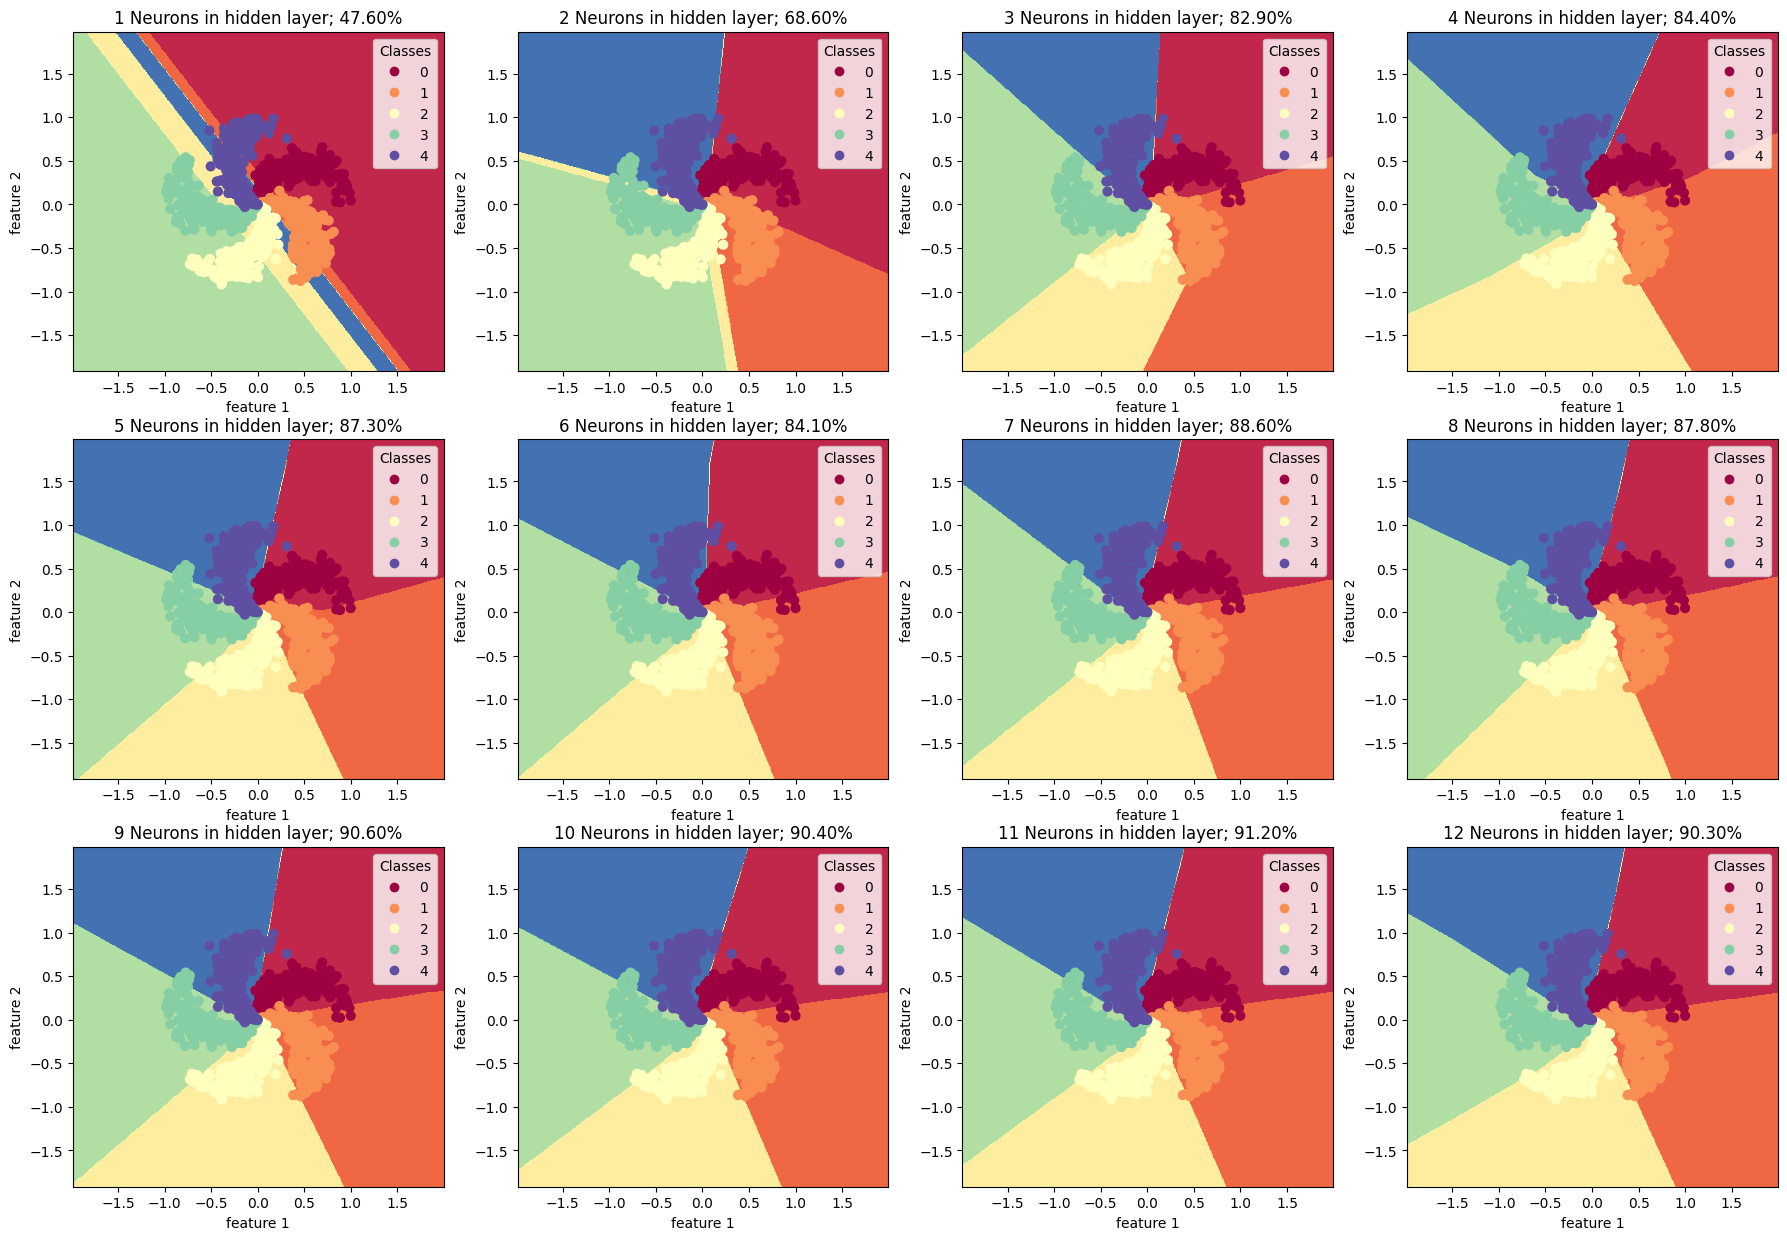

In [10]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1],1, 5]
plt.rcParams['figure.figsize'] = (22.0, 15.0) # width, height
for i in range(1,13):
    layers_dims=[X.shape[-1],i, 5]
    plt.subplot(3, 4, i)
    forward, costs = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
    Y_pred=forward(X)
    acc.reset_states()
    acc.update_state(Y_true, Y_pred)
    plot_decision_boundary(forward, X_np, Y_np)
    plt.title(f"{i} Neurons in hidden layer; {acc.result().numpy().item()*100:.2f}%")
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

### 3 Layers (or 2 hidden layer) Neural Network

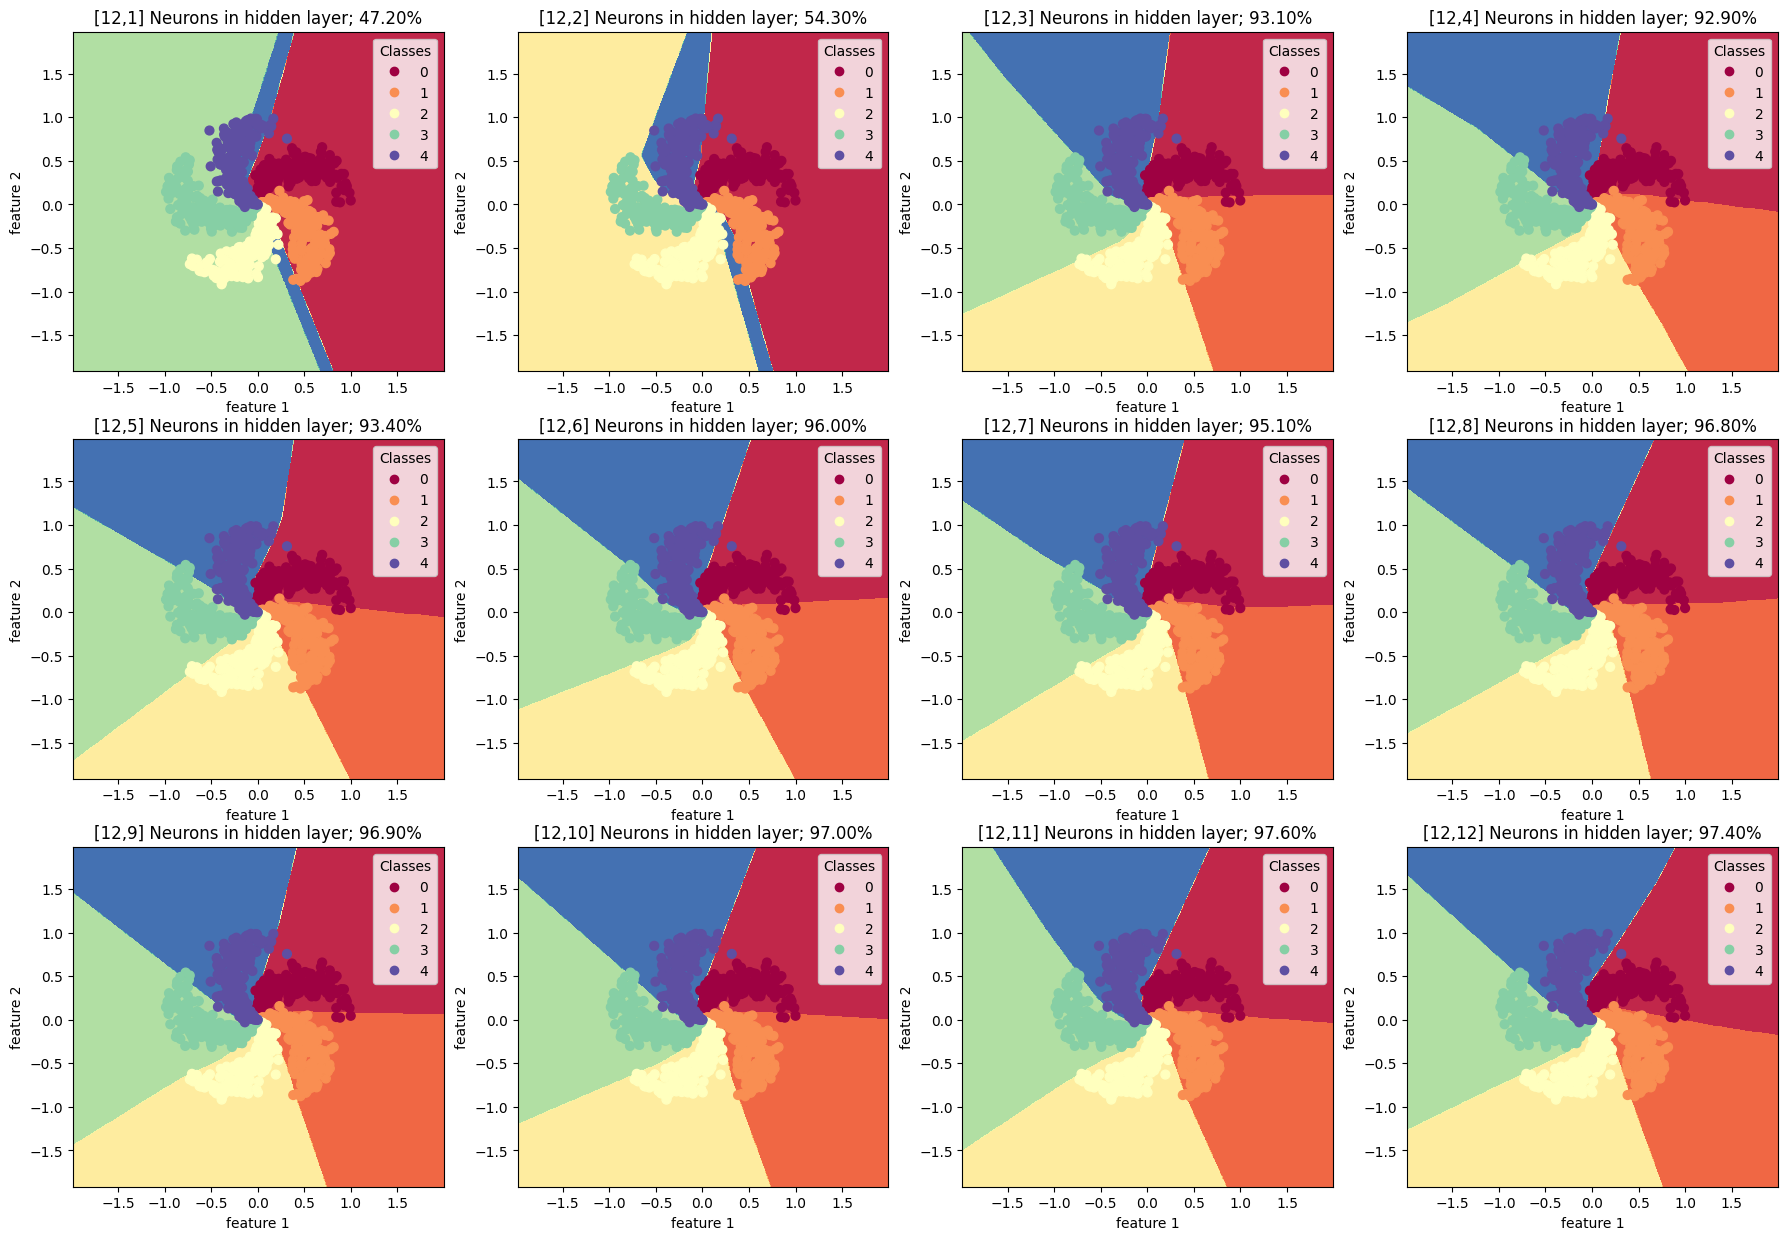

In [11]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1],12,1, 5]
plt.rcParams['figure.figsize'] = (22.0, 15.0) # width, height
for i in range(1,13):
    layers_dims=[X.shape[-1],12, i, 5]
    plt.subplot(3, 4, i)
    forward, costs = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
    Y_pred=forward(X)
    acc.reset_states()
    acc.update_state(Y_true, Y_pred)
    plot_decision_boundary(forward, X_np, Y_np)
    plt.title(f"[12,{i}] Neurons in hidden layer; {acc.result().numpy().item()*100:.2f}%")
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

### 4 Layers (or 3 hidden layer) Neural Network

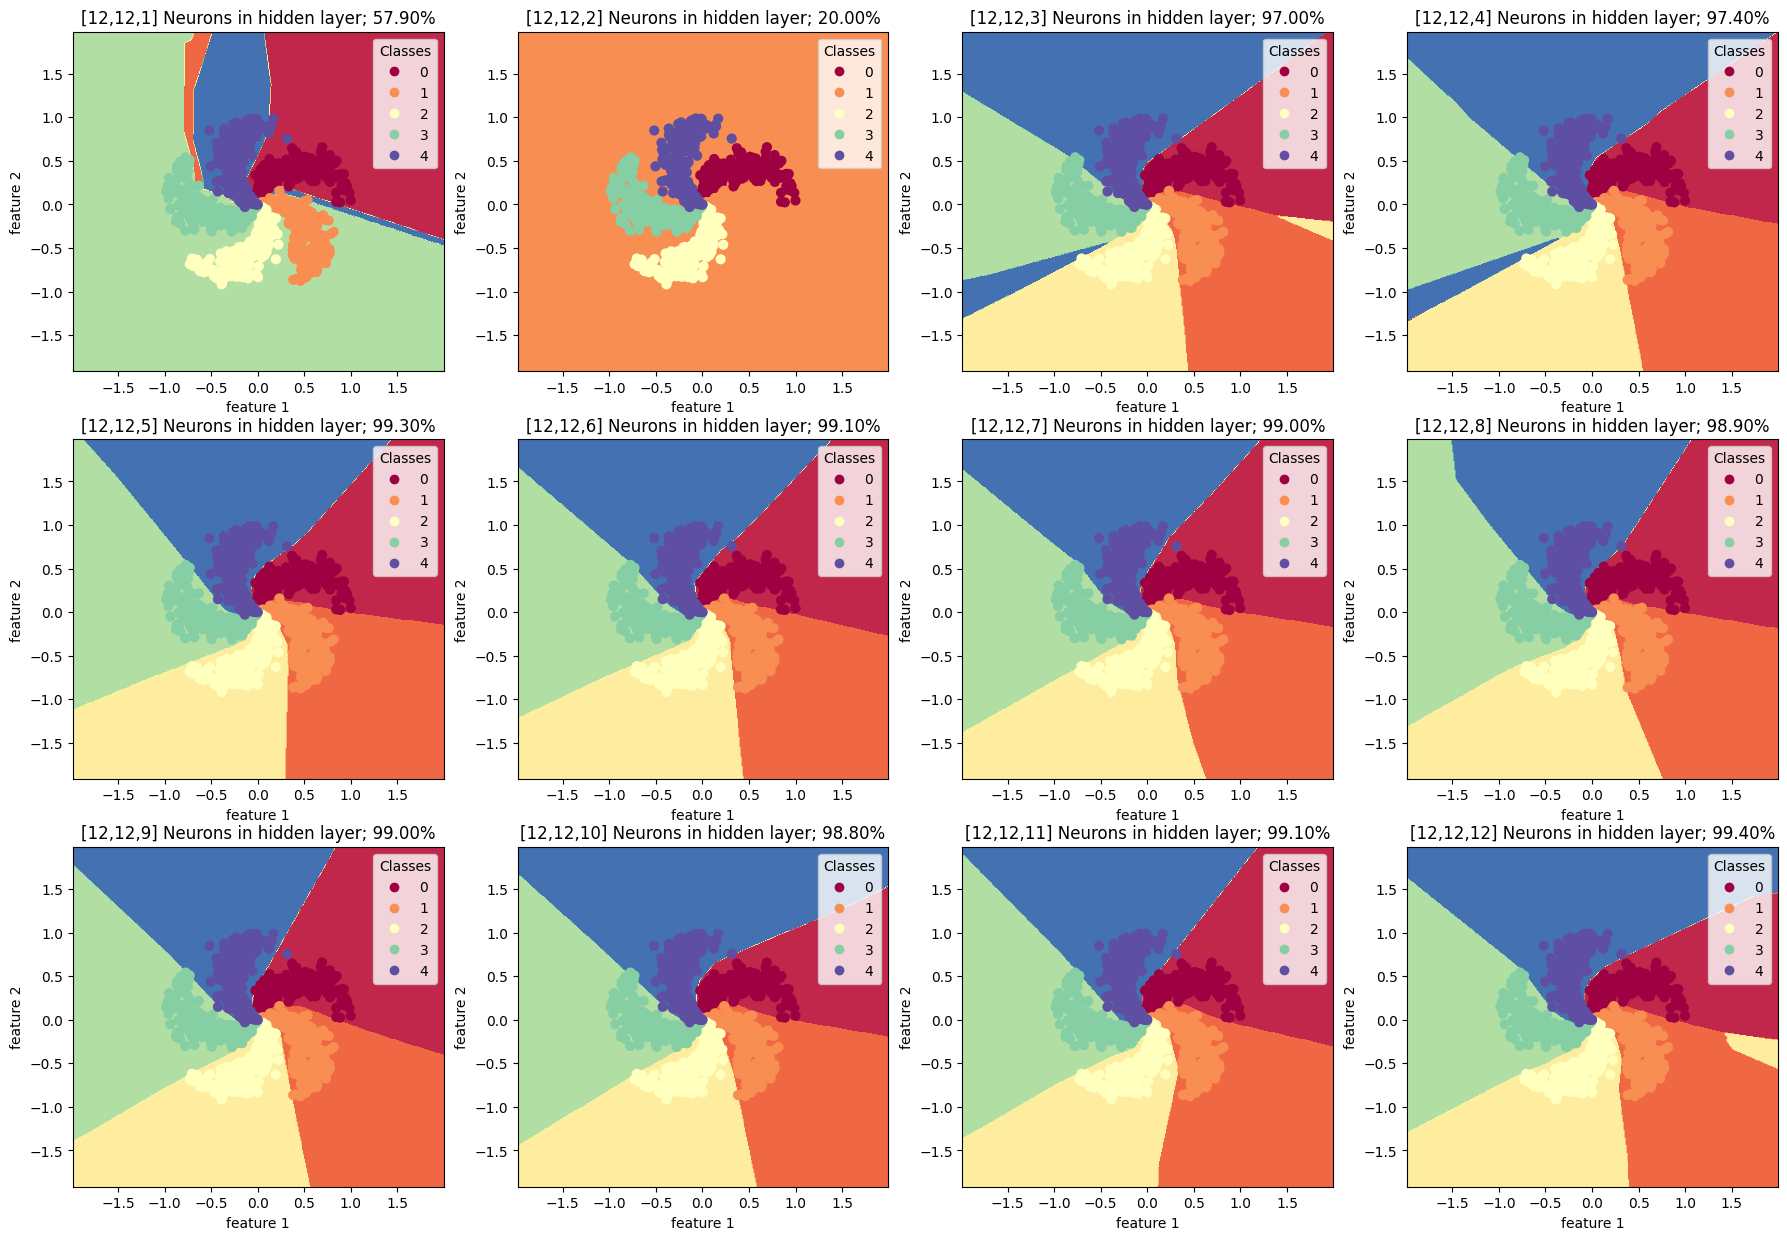

In [12]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1],12,12,1, 5]
plt.rcParams['figure.figsize'] = (22.0, 15.0) # width, height
for i in range(1,13):
    layers_dims=[X.shape[-1],12,12, i, 5]
    plt.subplot(3, 4, i)
    forward, costs = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
    Y_pred=forward(X)
    acc.reset_states()
    acc.update_state(Y_true, Y_pred)
    plot_decision_boundary(forward, X_np, Y_np)
    plt.title(f"[12,12,{i}] Neurons in hidden layer; {acc.result().numpy().item()*100:.2f}%")

### Conclusion

4 layer neural networks in general give best results and adding more layers is increasing accuracy by much but probably overfitting.

Text(0.5, 1.0, '[12,12,12] Neurons in hidden layer; 99.40%')

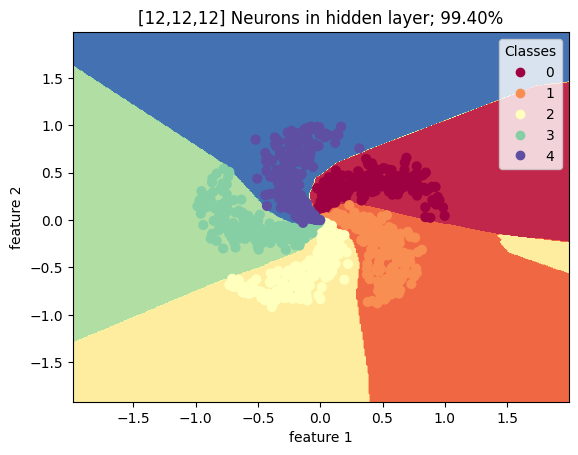

In [13]:
num_epochs=2000; activation_L_1="relu"; activation_L="softmax"
learning_rate = 0.0006; layers_dims=[X.shape[-1],12,12,12, 5]
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
forward, costs = L_layer_model(X, Y_true, layers_dims, learning_rate, num_epochs, activation_L_1, activation_L, print_cost=False)
Y_pred=forward(X)
acc.reset_states()
acc.update_state(Y_true, Y_pred)
# print(f"train accuracy: { acc.result().numpy().item() *100 } %")
# plot_costs(costs, learning_rate)
plot_decision_boundary(forward, X_np, Y_np)
plt.title(f"[12,12,12] Neurons in hidden layer; {acc.result().numpy().item()*100:.2f}%")